# Stock price prediction using LSTM

## Step 1: Import libraries and historical stock price data 

### 1.1: Import libraries

In [45]:
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [46]:
tf.__version__ # checking tensorflow version

'2.2.0'

### 1.2: Import ITC stock price data

In [50]:
df_1 = pd.read_csv('ITC.csv') # import dataset

In [51]:
df_1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-01,214.867004,215.600006,214.067001,214.932999,178.186478,1859278.0
1,2014-01-02,214.899994,216.667007,209.533005,209.966995,174.069519,6784786.0
2,2014-01-03,210.000000,210.667007,206.899994,209.832993,173.958420,11999877.0
3,2014-01-06,210.000000,211.132996,209.000000,210.432999,174.455841,8155128.0
4,2014-01-07,211.000000,211.600006,208.500000,211.132996,175.036163,7779138.0
...,...,...,...,...,...,...,...
1664,2020-10-05,171.100006,172.800003,168.750000,169.250000,169.250000,24298942.0
1665,2020-10-06,169.500000,171.600006,168.100006,169.899994,169.899994,21885190.0
1666,2020-10-07,170.000000,170.899994,169.000000,169.500000,169.500000,16286540.0
1667,2020-10-08,170.100006,170.399994,166.899994,167.149994,167.149994,25502126.0


In [52]:
df_2 = df_1[['Close']] # We will do our analysis using the closing prices although any feature can be used for analysis depending on the requirement
df = df_2.dropna() # drop any nan values
df

,Close
0,214.932999
1,209.966995
2,209.832993
3,210.432999
4,211.132996
...,...
1664,169.250000
1665,169.899994
1666,169.500000
1667,167.149994


In [53]:
df.isnull().any() #checking if any nan values in the dataset

Close    False
dtype: bool

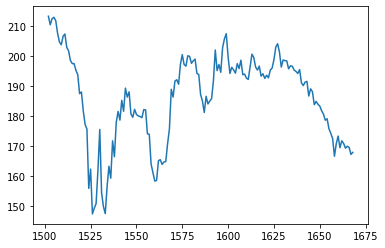

In [77]:
t = int(len(df)*0.9) # picking the 90% percentile point
df_test=df[t:] # Selecting recent 10% data 
plt.plot(df_test) # Plot last 10% of the data for vetter visualization

In [78]:
df1 = df.reset_index()['Close'] # resetting index
df1 = df1[:t]

df1

0       214.932999
1       209.966995
2       209.832993
3       210.432999
4       211.132996
           ...    
1494    235.149994
1495    207.600006
1496    215.649994
1497    216.449997
1498    213.550003
Name: Close, Length: 1499, dtype: float64

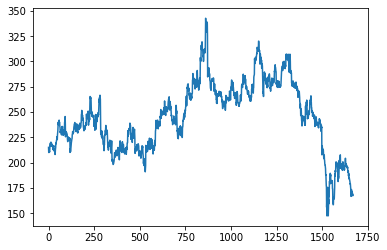

In [79]:
plt.plot(df) # plotting entire dataset for ITC stock

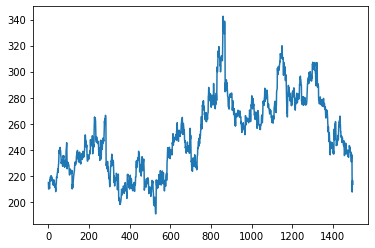

In [80]:
plt.plot(df1)

### 1.3: Perform feature scaling

In [81]:
# LSTM are sensitive to the scale of data. So we scale our values between 0 and 1 using MinMaxScaler

In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1)) # reshaping into one column
df1

array([[0.15908369],
       [0.12634801],
       [0.12546467],
       ...,
       [0.1638101 ],
       [0.16908368],
       [0.14996704]])

## Step 2: Prepare train and test data

### 2.1: Splitting the data into Train and Test set
### As this is time series data, we will not split the data randomly rather in continuous manner

In [83]:
training_size = int(len(df1)*0.65) # selecting first 65% entries for train set
test_size = len(df1) - training_size # remaining 35% for test set
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:1] # splitting the data into train and test set

In [84]:
training_size,test_size

(974, 525)

In [85]:
test_data

array([[0.48648652],
       [0.47725781],
       [0.48417929],
       [0.47791685],
       [0.47626886],
       [0.47659858],
       [0.48352006],
       [0.47033614],
       [0.46835863],
       [0.47758733],
       [0.47132489],
       [0.46110744],
       [0.46374418],
       [0.46638093],
       [0.47528011],
       [0.49307847],
       [0.52570855],
       [0.51812783],
       [0.52076458],
       [0.50593267],
       [0.50626239],
       [0.46736988],
       [0.49604474],
       [0.54449567],
       [0.55207638],
       [0.54614366],
       [0.56559001],
       [0.59756105],
       [0.59624258],
       [0.55932757],
       [0.55636131],
       [0.53131175],
       [0.55702035],
       [0.55735006],
       [0.58305866],
       [0.5451549 ],
       [0.55603159],
       [0.54911012],
       [0.53098223],
       [0.5210943 ],
       [0.4990112 ],
       [0.50955837],
       [0.49868168],
       [0.48319054],
       [0.47758733],
       [0.5102176 ],
       [0.50296641],
       [0.515

### 2.2: Function to create independent features set and dependent feature set for each time t (given input data and time stamp)
### By time stamp we mean, the number of entries before time t to consider when predicting the price at time t

In [86]:
def prepare_dataset(data, time_stamp):
    dataX,dataY=[],[]
    for i in range(len(data)-time_stamp-1):
        a=data[i:(i+time_stamp),0]
        dataX.append(a)
        dataY.append(data[i+time_stamp,0])
    return np.array(dataX), np.array(dataY)

In [87]:
time_stamp=60 # We select time stamp as 60, which indicates that we will consider 60 entries before time t to predict price at time t 
X_train, y_train = prepare_dataset(train_data, time_stamp) # creating train set
X_test, y_test = prepare_dataset(test_data, time_stamp) # creating test set

In [88]:
print(X_train.shape), print(y_train.shape)

(913, 60)
(913,)


(None, None)

In [89]:
print(X_test.shape), print(y_test.shape)

(464, 60)
(464,)


(None, None)

In [90]:
# reshape input to be [samples, time stamps, features] format, which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1) # One feature is one observation at a time step. 
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1) # One feature is one observation at a time step.

## Step 3: LSTM architecture and training
### 3.1: Import libraries from LSTM architecture

In [91]:
#Architecture of LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

### 3.2: Architecture of LSTM

In [92]:
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(60,1)))
#model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(50,return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(50))
#model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [93]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1) #training 

Epoch 1/100
15/15 [==============================] - 3s 223ms/step - loss: 0.0413 - val_loss: 0.0331
Epoch 2/100
15/15 [==============================] - 2s 115ms/step - loss: 0.0093 - val_loss: 0.0113
Epoch 3/100
15/15 [==============================] - 2s 119ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 4/100
15/15 [==============================] - 2s 119ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 5/100
15/15 [==============================] - 2s 117ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 6/100
15/15 [==============================] - 2s 129ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 7/100
15/15 [==============================] - 2s 115ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 8/100
15/15 [==============================] - 2s 116ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 9/100
15/15 [==============================] - 2s 116ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 10/100
15/15 [==============================] - 2s 116ms/step - loss: 0.0038 - val_lo

15/15 [==============================] - 2s 131ms/step - loss: 8.9288e-04 - val_loss: 8.2203e-04
Epoch 80/100
15/15 [==============================] - 2s 110ms/step - loss: 8.6479e-04 - val_loss: 6.5493e-04
Epoch 81/100
15/15 [==============================] - 2s 110ms/step - loss: 8.2564e-04 - val_loss: 8.4573e-04
Epoch 82/100
15/15 [==============================] - 2s 111ms/step - loss: 8.3906e-04 - val_loss: 6.4897e-04
Epoch 83/100
15/15 [==============================] - 2s 111ms/step - loss: 8.0566e-04 - val_loss: 0.0010
Epoch 84/100
15/15 [==============================] - 2s 112ms/step - loss: 9.4164e-04 - val_loss: 7.1582e-04
Epoch 85/100
15/15 [==============================] - 2s 116ms/step - loss: 8.4567e-04 - val_loss: 7.6268e-04
Epoch 86/100
15/15 [==============================] - 2s 114ms/step - loss: 9.0531e-04 - val_loss: 6.7313e-04
Epoch 87/100
15/15 [==============================] - 2s 109ms/step - loss: 8.6213e-04 - val_loss: 9.0482e-04
Epoch 88/100
15/15 [=======

## Step 4: Predicting and plotting train and test results 

In [95]:
# predict the results on X_train and X_test
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


In [96]:
print(train_predict.shape)
print(test_predict.shape)

(913, 1)
(464, 1)


In [97]:
# perform inverse transformation on transformed values
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [98]:
# Evaluate RMSE value
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

243.354710004832

In [99]:
# Test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

273.62056176494474

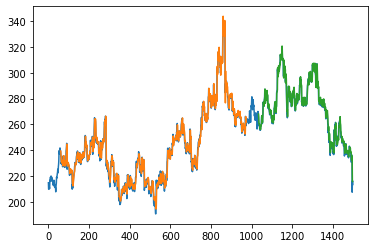

In [100]:
# plot train and test prediction with baseline
# train plot
look_back=60
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:, :]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
# test plot
testPredictPlot=np.empty_like(df1)
testPredictPlot[:, :]=np.nan
testPredictPlot[len(train_predict)+look_back*2+1:len(df1)-1,:] = test_predict
# plot all
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

## Step 5: Predicting next 30 days prices

In [101]:
test_data

array([[0.48648652],
       [0.47725781],
       [0.48417929],
       [0.47791685],
       [0.47626886],
       [0.47659858],
       [0.48352006],
       [0.47033614],
       [0.46835863],
       [0.47758733],
       [0.47132489],
       [0.46110744],
       [0.46374418],
       [0.46638093],
       [0.47528011],
       [0.49307847],
       [0.52570855],
       [0.51812783],
       [0.52076458],
       [0.50593267],
       [0.50626239],
       [0.46736988],
       [0.49604474],
       [0.54449567],
       [0.55207638],
       [0.54614366],
       [0.56559001],
       [0.59756105],
       [0.59624258],
       [0.55932757],
       [0.55636131],
       [0.53131175],
       [0.55702035],
       [0.55735006],
       [0.58305866],
       [0.5451549 ],
       [0.55603159],
       [0.54911012],
       [0.53098223],
       [0.5210943 ],
       [0.4990112 ],
       [0.50955837],
       [0.49868168],
       [0.48319054],
       [0.47758733],
       [0.5102176 ],
       [0.50296641],
       [0.515

In [102]:
start=len(test_data)-time_stamp
input_val=test_data[start:].reshape(1,-1)
print(input_val.shape)
input_val

(1, 60)


array([[0.41595249, 0.39452862, 0.39518786, 0.38562954, 0.39485824,
        0.36189845, 0.37475275, 0.37541199, 0.38464069, 0.3701384 ,
        0.36849041, 0.3665128 , 0.35695448, 0.35102176, 0.34508894,
        0.3701384 , 0.34640741, 0.33388263, 0.29531974, 0.30850365,
        0.31476599, 0.33487148, 0.3038892 , 0.33124589, 0.35827285,
        0.35299937, 0.33190502, 0.31707312, 0.31608436, 0.30323007,
        0.3038892 , 0.31245877, 0.30916279, 0.31179963, 0.32333556,
        0.31443637, 0.29202376, 0.29367175, 0.28609094, 0.29663811,
        0.3111404 , 0.31938034, 0.34574817, 0.34014497, 0.32926828,
        0.32399469, 0.33684899, 0.31410676, 0.31147001, 0.31048116,
        0.31212915, 0.28872778, 0.2633487 , 0.30224121, 0.28510218,
        0.29235328, 0.11074491, 0.1638101 , 0.16908368, 0.14996704]])

In [103]:
temp_input = list(input_val)
temp_input=temp_input[0].tolist()
print(len(temp_input))
temp_input

60


[0.41595248680196084,
 0.3945286234910077,
 0.3951878588369384,
 0.38562953959715607,
 0.39485824116397317,
 0.3618984514548145,
 0.3747527496655123,
 0.37541198501144324,
 0.3846406865782599,
 0.3701383988821043,
 0.36849040939664635,
 0.3665128022382227,
 0.3569544829984408,
 0.35102176040253963,
 0.34508893892726955,
 0.3701383988821043,
 0.3464074096191314,
 0.3338826302020297,
 0.2953197355699355,
 0.3085036514535988,
 0.314765991722465,
 0.33487148322092586,
 0.30388920179082124,
 0.33124588657704424,
 0.3582728548109331,
 0.35299936756096306,
 0.33190502304360603,
 0.31707311767448476,
 0.3160843635349577,
 0.30323006532425945,
 0.30388920179082124,
 0.31245876689107654,
 0.3091627879201606,
 0.31179963042451475,
 0.3233355568227203,
 0.31443637404949976,
 0.2920237565990196,
 0.29367174608447755,
 0.2860909351237497,
 0.2966381073824278,
 0.3111403950785838,
 0.31938034250587344,
 0.3457481742732005,
 0.34014497047089587,
 0.32926827941862125,
 0.3239946932892821,
 0.3368489914

In [105]:
# Logic to predict the future values
predicted_list=[]
n_steps=60
i=0

while(i<30):
    if(len(temp_input)>60):
        input_val=np.array(temp_input[1:])
        print("{} day input {}".format(i,input_val))
        input_val=input_val.reshape(1,-1)
        input_val=input_val.reshape(1,n_steps,1)
        yhat=model.predict(input_val,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        predicted_list.extend(yhat.tolist())
        i=i+1
    else:
        input_val=input_val.reshape(1,n_steps,1)
        yhat=model.predict(input_val,verbose=0)
        print(yhat)
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        predicted_list.extend(yhat.tolist())
        i=i+1

print(predicted_list)

[[0.16775064]]
61
1 day input [0.39452862 0.39518786 0.38562954 0.39485824 0.36189845 0.37475275
 0.37541199 0.38464069 0.3701384  0.36849041 0.3665128  0.35695448
 0.35102176 0.34508894 0.3701384  0.34640741 0.33388263 0.29531974
 0.30850365 0.31476599 0.33487148 0.3038892  0.33124589 0.35827285
 0.35299937 0.33190502 0.31707312 0.31608436 0.30323007 0.3038892
 0.31245877 0.30916279 0.31179963 0.32333556 0.31443637 0.29202376
 0.29367175 0.28609094 0.29663811 0.3111404  0.31938034 0.34574817
 0.34014497 0.32926828 0.32399469 0.33684899 0.31410676 0.31147001
 0.31048116 0.31212915 0.28872778 0.2633487  0.30224121 0.28510218
 0.29235328 0.11074491 0.1638101  0.16908368 0.14996704 0.16775064]
1 day output [[0.17363462]]
2 day input [0.39518786 0.38562954 0.39485824 0.36189845 0.37475275 0.37541199
 0.38464069 0.3701384  0.36849041 0.3665128  0.35695448 0.35102176
 0.34508894 0.3701384  0.34640741 0.33388263 0.29531974 0.30850365
 0.31476599 0.33487148 0.3038892  0.33124589 0.35827285 0.3

14 day output [[0.22551496]]
15 day input [0.3701384  0.34640741 0.33388263 0.29531974 0.30850365 0.31476599
 0.33487148 0.3038892  0.33124589 0.35827285 0.35299937 0.33190502
 0.31707312 0.31608436 0.30323007 0.3038892  0.31245877 0.30916279
 0.31179963 0.32333556 0.31443637 0.29202376 0.29367175 0.28609094
 0.29663811 0.3111404  0.31938034 0.34574817 0.34014497 0.32926828
 0.32399469 0.33684899 0.31410676 0.31147001 0.31048116 0.31212915
 0.28872778 0.2633487  0.30224121 0.28510218 0.29235328 0.11074491
 0.1638101  0.16908368 0.14996704 0.16775064 0.17363462 0.17985429
 0.18509831 0.18945964 0.19322985 0.19672653 0.20020199 0.2038011
 0.20755699 0.21141399 0.21526119 0.2189686  0.22241676 0.22551496]
15 day output [[0.22821082]]
16 day input [0.34640741 0.33388263 0.29531974 0.30850365 0.31476599 0.33487148
 0.3038892  0.33124589 0.35827285 0.35299937 0.33190502 0.31707312
 0.31608436 0.30323007 0.3038892  0.31245877 0.30916279 0.31179963
 0.32333556 0.31443637 0.29202376 0.29367175 

28 day output [[0.2408911]]
29 day input [0.30323007 0.3038892  0.31245877 0.30916279 0.31179963 0.32333556
 0.31443637 0.29202376 0.29367175 0.28609094 0.29663811 0.3111404
 0.31938034 0.34574817 0.34014497 0.32926828 0.32399469 0.33684899
 0.31410676 0.31147001 0.31048116 0.31212915 0.28872778 0.2633487
 0.30224121 0.28510218 0.29235328 0.11074491 0.1638101  0.16908368
 0.14996704 0.16775064 0.17363462 0.17985429 0.18509831 0.18945964
 0.19322985 0.19672653 0.20020199 0.2038011  0.20755699 0.21141399
 0.21526119 0.2189686  0.22241676 0.22551496 0.22821082 0.23048979
 0.23237033 0.23389333 0.23511392 0.23609085 0.23688267 0.23754245
 0.23811777 0.23864762 0.23916516 0.23969777 0.24026743 0.2408911 ]
29 day output [[0.24158122]]
[[0.16775064170360565], [0.1736346185207367], [0.17985428869724274], [0.1850983053445816], [0.1894596368074417], [0.19322985410690308], [0.19672653079032898], [0.20020198822021484], [0.20380109548568726], [0.20755699276924133], [0.21141399443149567], [0.2152611

In [106]:
day_new=np.arange(1,61)
day_pred=np.arange(61,91)

In [107]:
print(len(df1))
print(len(df1)-time_stamp)

1499
1439


In [108]:
df_final=df1.tolist()
df_final.extend(predicted_list)

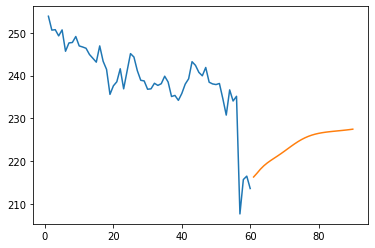

In [109]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-time_stamp:]))
plt.plot(day_pred,scaler.inverse_transform(predicted_list))

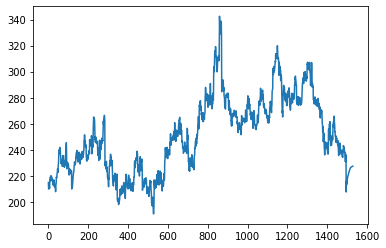

In [110]:
plt.plot(scaler.inverse_transform(df_final))

## Here we are indicated not about exact values but a trend that the stock could follow in upcoming trading session